The purpose of this analysis to find out the most important features that influence how people rate wines. Data used in this analysis was scraped from vivino.com using self written API client available at:
https://github.com/sansar-choinyambuu/vivino-scraper

# 1. Data extraction

Let us prepare the data from pickled input into pandas dataframe, containing only interesting features

In [2]:
# only when running on colab to copy wines.pickle from google drive
from google.colab import drive
drive.mount('/content/drive')
!cp "/content/drive/My Drive/vivino/wines.pickle" wines.pickle

Mounted at /content/drive


In [4]:
import pandas as pd
import pickle
%matplotlib inline

In [5]:
# assuming wines.pickle file in the same folder as this notebook. The pickle is produced by vivino-scraper
wines_pickle = pickle.load(open("wines.pickle", "rb"))
wines_complete = pd.DataFrame(wines_pickle)

In [6]:
# Pick the interesting features only
wines_df = pd.DataFrame()
wines_df["id"] = wines_complete["vintage"].apply(lambda x: x["id"])
wines_df["name"] = wines_complete["vintage"].apply(lambda x: x["name"])
wines_df["price_chf"] = wines_complete["price"].apply(lambda x: x["amount"])
wines_df["price_seg"] = pd.cut(wines_df["price_chf"], bins = [0,20,40,80,1000000], labels=["cheap", "average", "expensive","very expensive"])
wines_df["rating_avg"] = wines_complete["vintage"].apply(lambda x: x["statistics"]["ratings_average"])
wines_df["rating_seg"] = pd.cut(wines_df["rating_avg"], bins = [0,3.5,4,4.5,5], labels=["average", "good", "very good", "extra ordinary"])
wines_df["ratings"] = wines_complete["vintage"].apply(lambda x: x["statistics"]["ratings_count"])
wine_type_map = {1: "red", 2: "white", 3: "sparkling", 4: "rose", 7: "desert", 24: "fortified"}
wines_df["type"] = wines_complete["vintage"].apply(lambda x: wine_type_map.get(x["wine"]["type_id"], "other")).astype('category')
wines_df["year"] = wines_complete["vintage"].apply(lambda x: x["year"]).astype('category')
wines_df["country"] = wines_complete["vintage"].apply(lambda x: x["wine"]["region"]["country"]["seo_name"] if x["wine"]["region"] is not None else None).astype('category')
wines_df["region"] = wines_complete["vintage"].apply(lambda x: x["wine"]["region"]["seo_name"] if x["wine"]["region"] is not None else None).astype('category')

def extract_main_grape(vintage):
    grapes = vintage["wine"]["style"]["grapes"] if vintage["wine"]["style"] is not None and vintage["wine"]["style"]["grapes"] is not None else None
    if grapes is None:
        return "unknown"
    else:
        return grapes[0]["seo_name"]
wines_df["main_grape"] = wines_complete["vintage"].apply(extract_main_grape).astype('category')

def extract_cuvee(vintage):
    grapes = vintage["wine"]["style"]["grapes"] if vintage["wine"]["style"] is not None and vintage["wine"]["style"]["grapes"] is not None else None
    if grapes is None or len(grapes) <= 1:
        return False
    else:
        return True
wines_df["cuvee"] = wines_complete["vintage"].apply(extract_cuvee)

# 2. Exploratory analysis

In [7]:
wines_df.head()

,id,name,price_chf,price_seg,rating_avg,rating_seg,ratings,type,year,country,region,main_grape,cuvee
0,156316934,Bromeus Nero d'Avola 2018,1.125000,cheap,3.6,good,118,red,2018,italy,sicily,primitivo,True
1,1727833,Emiliana Adobe Syrah (Reserva) 2012,1.783333,cheap,3.3,average,312,red,2012,chile,rapel-valley,shiraz-syrah,False
2,1421261,Emiliana Adobe Cabernet Sauvignon (Reserva) 2011,1.883333,cheap,3.2,average,1283,red,2011,chile,rapel-valley,cabernet-sauvignon,False
3,152421468,Barahonda Organic Monastrell - Syrah 2017,2.600000,cheap,3.9,good,102,red,2017,spain,yecla,grenache-noir,True
4,157517775,Les Bugadelles Réserve 2017,2.550000,cheap,3.8,good,122,red,2017,france,languedoc-la-clape,shiraz-syrah,True


In [8]:
wines_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45082 entries, 0 to 45081
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   id          45082 non-null  int64   
 1   name        45082 non-null  object  
 2   price_chf   45082 non-null  float64 
 3   price_seg   45082 non-null  category
 4   rating_avg  45082 non-null  float64 
 5   rating_seg  45082 non-null  category
 6   ratings     45082 non-null  int64   
 7   type        45082 non-null  category
 8   year        45082 non-null  category
 9   country     45047 non-null  category
 10  region      45047 non-null  category
 11  main_grape  45082 non-null  category
 12  cuvee       45082 non-null  bool    
dtypes: bool(1), category(7), float64(2), int64(2), object(1)
memory usage: 2.2+ MB


In [9]:
wines_df.describe()

,id,price_chf,rating_avg,ratings
count,4.508200e+04,45082.000000,45082.000000,45082.000000
mean,8.149331e+07,94.056762,4.004587,336.769753
std,7.062051e+07,491.174358,0.312351,1166.575805
min,2.036000e+03,1.125000,2.300000,25.000000
25%,4.470992e+06,18.360000,3.800000,52.000000
50%,9.204720e+07,31.620000,4.000000,109.000000
75%,1.530767e+08,64.210000,4.200000,281.000000
max,1.654104e+08,28503.700000,4.900000,90770.000000


### Let us explore data along few potentially interesting features

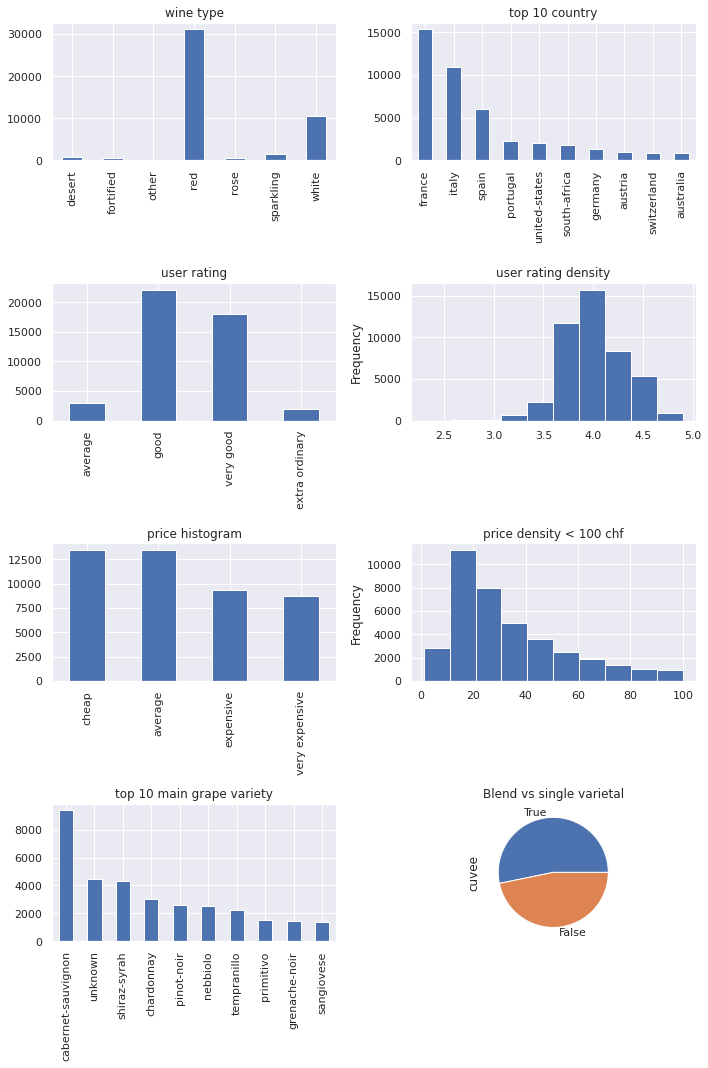

In [90]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

sns.set()

rcParams.update({'figure.autolayout': True})
f, axs = plt.subplots(4, 2)
f.set_size_inches(10,15)

wines_df["type"].value_counts(sort=False).plot(ax=axs[0,0], kind = "bar", title= "wine type")
wines_df["country"].value_counts(sort=True)[:10].plot(ax=axs[0,1], kind='bar', title = "top 10 country")
wines_df["rating_seg"].value_counts(sort=False).plot(ax=axs[1,0], kind='bar', title = "user rating")
wines_df["rating_avg"].plot(ax=axs[1,1], kind='hist', title = "user rating density")
wines_df["price_seg"].value_counts(sort=False).plot(ax=axs[2,0], kind='bar', title = "price histogram")
wines_df[wines_df["price_chf"] < 100]["price_chf"].plot(ax=axs[2,1], kind='hist', title = "price density < 100 chf")
wines_df["main_grape"].value_counts(sort=True)[:10].plot(ax=axs[3,0], kind='bar', title = "top 10 main grape variety")
wines_df["cuvee"].value_counts(sort=True).plot(ax=axs[3,1], kind='pie', title = "Blend vs single varietal");

### Let us see some joint plots to visually discover potential correlations

**Expensive wines get higher user ratings?**

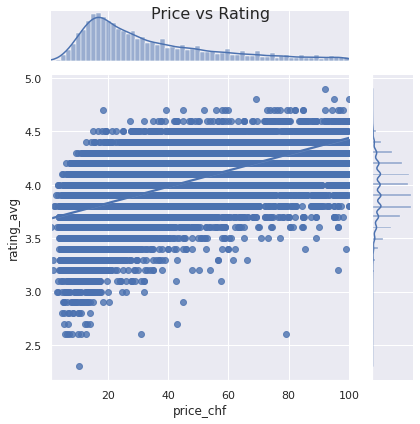

In [89]:
wines_upto_100 = wines_df[wines_df["price_chf"] <= 100]
sns.jointplot(x="price_chf", y="rating_avg", data=wines_upto_100, kind='reg')
plt.suptitle('Price vs Rating', fontsize=16);

*There seems to be positive correlation between price and average user ratings of the wines*

**Is french really better?**

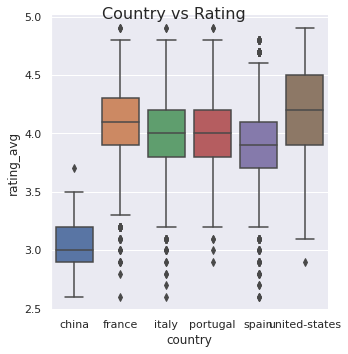

In [88]:
wines_fr_it_es_pt = wines_df[wines_df.country.isin(["italy", "france", "spain", "portugal", "united-states", "china"])].copy()
wines_fr_it_es_pt.country.cat.remove_unused_categories(inplace=True)
sns.catplot(x="country", y="rating_avg", data=wines_fr_it_es_pt, kind='box')
plt.suptitle('Country vs Rating', fontsize=16);

*French wines do seem to get higher user ratings on average in comparison with other top wine producing countries. However american wines even foreshadow french ones.*

# 3. Data preparation for machine learning

Drop the wines without region

In [15]:
wines_df.dropna(inplace = True)
len(wines_df)

45047

Seperate input and target features. For prediction of the user rating class: id, name, ratings count and price segment features were excluded.

In [16]:
wines_x = wines_df[["price_chf", "type", "year", "country", "region", "main_grape", "cuvee"]].copy()
wines_y = wines_df["rating_seg"].copy()

In [17]:
# Full pipe with column transformer on each feature that needs data prep
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

pipeline = ColumnTransformer([
    ("price_scaling", StandardScaler(), ["price_chf"]),
    ("type_encoding", OneHotEncoder(categories = [sorted(wines_x["type"].unique())]), ["type"]),
    ("year_encoding", OneHotEncoder(categories = [wines_x["year"].unique()]), ["year"]),
    ("country_encoding", OneHotEncoder(categories = [sorted(wines_x["country"].unique())]), ["country"]),
    ("region_encoding", OneHotEncoder(categories = [sorted(wines_x["region"].unique())]), ["region"]),
    ("main_grape_encoding", OneHotEncoder(categories = [sorted(wines_x["main_grape"].unique())]), ["main_grape"]),
    ("cuvee_encoding", OneHotEncoder(categories = [sorted(wines_x["cuvee"].unique())]), ["cuvee"]),
], remainder = "passthrough")

In [18]:
# run data prep pipeline on all input data
wines_x_prepared = pipeline.fit_transform(wines_x)
print(type(wines_x_prepared))
print(wines_x_prepared.shape)

<class 'scipy.sparse.csr.csr_matrix'>
(45047, 1679)


Split the data into train, test sets. Hyperparameters will be optimized on cross validation sets.

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(wines_x_prepared, wines_y, stratify=wines_y, test_size=0.15)
# X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, stratify=y_train, test_size=0.176)

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

#print(X_dev.shape)
#print(y_dev.shape)

(38289, 1679)
(38289,)
(6758, 1679)
(6758,)


# 4. Prediction model that classifies wine user ratings given other features of the wine
Vivino user rating segments are defined based on average user rating:
- 0 - 3.5 average
- 3.5 - 4 good
- 4 - 4.5 very good
- 4.5 - 5 extra ordinary  

Let us try to train a classification model that predicts the user rating of the wines based on the following input features:
- Price - bottle price in chf
- Type - wine types i.e. red, white, sparkling, rose etc
- Year
- Country
- Region - wine region within a country i.e. Bordeaux
- Main grape - i.e. cabernet-sauvignon
- Cuvee - true if wine is a blend of multiple grape varieties, false otherwise

## 4.1 Model selection

In [22]:
import sklearn.linear_model
import sklearn.tree
import sklearn.ensemble
import sklearn.kernel_ridge
import sklearn.neighbors
import sklearn.svm
import sklearn.cross_decomposition
import sklearn.compose

from sklearn.metrics import accuracy_score
import numpy as np

import warnings

class Classifier:
    def __init__(self, label, model):
        self.label = label
        self.model = model
        self.training_accuracy = 0.0
        self.validation_accuracy = 0.0

def fit_eval(classifier, x_tr, x_val, y_tr, y_val):
    warnings.filterwarnings('ignore')
    try:
        classifier.model.fit(x_tr.toarray(), y_tr)
        
        # training accuracy
        tr_pred = classifier.model.predict(x_tr.toarray())
        classifier.training_accuracy = accuracy_score(y_tr, tr_pred)
        
        # validation accuracy
        val_pred = classifier.model.predict(x_val.toarray())
        classifier.validation_accuracy = accuracy_score(val_y, val_pred)
        
    except (ValueError, MemoryError, IndexError) as e:
        print(f"{type(e)} while training {classifier.label}")

### Train and evaluate all classifiers available in sklearn

In [27]:
import sklearn.utils.testing
from collections import namedtuple

# split training data in seperate training and validation set
train_x, val_x, train_y, val_y = train_test_split(X_train, y_train, stratify=y_train, test_size=0.15)

# train and evaluate all classifiers available in sklearn
estimators = [e for e in sklearn.utils.testing.all_estimators(type_filter='classifier') if e[1] is not None]
for estimator in estimators:
    classifier = Classifier(estimator[0], estimator[1]())
    fit_eval(classifier, train_x, val_x, train_y, val_y)
    print(f"{classifier.label} training accuracy: {classifier.training_accuracy}, validation accuracy: {classifier.validation_accuracy}")

AdaBoostClassifier training accuracy: 0.695805807343678, validation accuracy: 0.6861072423398329
BaggingClassifier training accuracy: 0.9681671531725303, validation accuracy: 0.6814066852367688
BernoulliNB training accuracy: 0.6349055154401598, validation accuracy: 0.6084610027855153
CalibratedClassifierCV training accuracy: 0.6927638654171148, validation accuracy: 0.6716573816155988
<class 'IndexError'> while training CategoricalNB
CategoricalNB training accuracy: 0.6348747887540329, validation accuracy: 0.0
<class 'ValueError'> while training CheckingClassifier
CheckingClassifier training accuracy: 0.0, validation accuracy: 0.0


TypeError: ignored

From all classifiers available in sklearn - GradientBoostingClassifier with 0.722, LogisticRegression with 0.69, MLPClassifier with 0.686, AdaBoostClassifier with 0.685 and BaggingClassifier with 0.685 have highest accuracy score. The classifiers are all used with default hyper parameters. Some classifiers such as DecisionTreeClassifier, ExtraTreeClassifier and RandomForestClassifier have produced training accuracy over 90% but failed to perform on validation set, thus overfitting the training set.

From the best performing models, the LogisticRegression was chosen to be optimized further. The primary reason for this choice is due to possibilities to explain feature importances based on the LogisticRegression's linear model coefficients.

## 4.2 Hyperparameter tuning

 Let us perform a hyper parameter tuning via cross validation to find the optimal set of hyper parameters for the LogisticRegression model.

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import numpy as np

# Search space for hyper parameters
hyperparameters = {'penalty': ["l1","l2"],
                   'C': np.logspace(-4, 4, 20),
                   'solver': ["liblinear"]}

grid_cv = GridSearchCV(estimator=LogisticRegression(),
            param_grid=hyperparameters,
            cv=5,
            scoring = 'accuracy',
            n_jobs = -1,
            verbose = 5, 
            return_train_score = True,
            refit = True)
grid_cv.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 13.6min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': array([1.00000000e-04, 2.636...
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
      

In [29]:
best_score_idx = np.argmin(grid_cv.cv_results_["rank_test_score"])
grid_cv.cv_results_["mean_test_score"][best_score_idx]

0.6934628954474819

The LogisticRegression model with tuned hyperparameters C=1.0, penalty='l2' produced mean accuracy 0.69 on cross validation.

## 4.3 Neural network for user rating classification
We have trained "traditional" classifiers available in sklearn for our user rating classification tasks. Would simple neural network yield better classification accuracy? Note however that neural networks would contribute little to our goal of explaining important features that influence user ratings.

In [61]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam

model = Sequential()

model.add(Dense(500, activation='relu'))
model.add(Dropout(0.6))
model.add(BatchNormalization())

model.add(Dense(100, activation='relu'))
model.add(Dropout(0.6))
model.add(BatchNormalization())

model.add(Dense(50, activation='relu'))
model.add(Dropout(0.6))
model.add(BatchNormalization())

model.add(Dense(4, activation='softmax'))

optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

train_y_cat = pd.get_dummies(train_y).to_numpy()
val_y_cat = pd.get_dummies(val_y).to_numpy()

history = model.fit(train_x, train_y_cat, validation_data = (val_x, val_y_cat), epochs=50, batch_size=32, verbose = 1)
model.summary()

Epoch 1/50
1018/1018 [==============================] - 5s 5ms/step - loss: 1.0872 - accuracy: 0.5263 - val_loss: 0.8548 - val_accuracy: 0.6269
Epoch 2/50
1018/1018 [==============================] - 5s 5ms/step - loss: 0.8631 - accuracy: 0.6332 - val_loss: 0.7988 - val_accuracy: 0.6647
Epoch 3/50
1018/1018 [==============================] - 5s 5ms/step - loss: 0.8051 - accuracy: 0.6629 - val_loss: 0.7621 - val_accuracy: 0.6912
Epoch 4/50
1018/1018 [==============================] - 5s 5ms/step - loss: 0.7758 - accuracy: 0.6759 - val_loss: 0.7533 - val_accuracy: 0.6943
Epoch 5/50
1018/1018 [==============================] - 5s 5ms/step - loss: 0.7596 - accuracy: 0.6856 - val_loss: 0.7464 - val_accuracy: 0.6983
Epoch 6/50
1018/1018 [==============================] - 5s 5ms/step - loss: 0.7456 - accuracy: 0.6920 - val_loss: 0.7342 - val_accuracy: 0.6983
Epoch 7/50
1018/1018 [==============================] - 5s 5ms/step - loss: 0.7409 - accuracy: 0.6943 - val_loss: 0.7317 - val_accuracy:

Let us plot the training and validation loss as well as training and validation accuracy

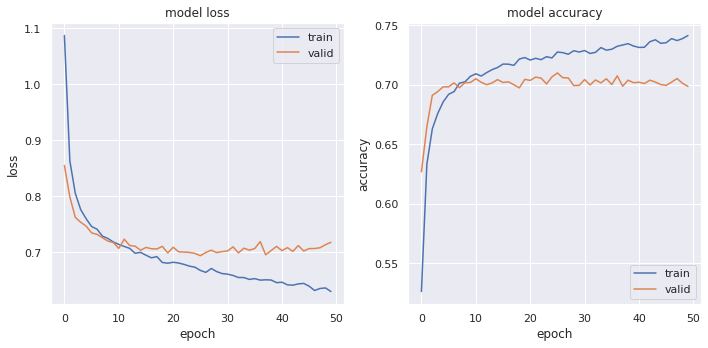

In [87]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches([10,5])

ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set_title('model loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'valid'], loc='upper right')

ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.set_title('model accuracy')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'valid'], loc='lower right');

Validation set loss and accuracy is not improving, although the training set loss is decreasing and accuracy getting better with training epochs. This hints at high bias of the model. Adding more relevant features to the model will probably improve the performance. This simple classification neural network's validation accuracy is 70%

## 4.4. Model analysis

### 4.4.1 Confusion matrix

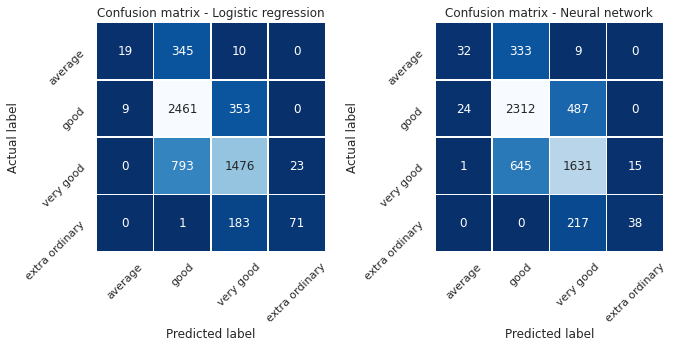

In [122]:
from sklearn import metrics

categories = val_y.cat.categories

logreg_preds = grid_cv.best_estimator_.predict(val_x)
nn_preds = categories[np.argmax(model.predict(val_x), axis=1)]

logreg_cm = metrics.confusion_matrix(val_y, logreg_preds, labels = categories)
nn_cm = metrics.confusion_matrix(val_y, nn_preds, labels = categories)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches([10,5])

sns.heatmap( ax=ax1, data = logreg_cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r', cbar=False)
ax1.set_ylabel('Actual label')
ax1.set_xlabel('Predicted label')
ax1.set_xticklabels(categories, rotation=45)
ax1.set_yticklabels(categories, rotation=45)
ax1.set_title("Confusion matrix - Logistic regression");

sns.heatmap( ax=ax2, data = nn_cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r', cbar=False)
ax2.set_ylabel('Actual label')
ax2.set_xlabel('Predicted label')
ax2.set_xticklabels(categories, rotation=45)
ax2.set_yticklabels(categories, rotation=45)
ax2.set_title("Confusion matrix - Neural network");

Both logistic regression and neural networks classifiers are making lots of mistakes for two of the smaller classes - average and extra ordinary. The good and very good categories seems to get confused with each other as well.

### 4.4.2 Feature importance

Let us move to the original aim, defined in the beginning of this notebook. We want to understand what features are most important for determining user ratings for wines.

In [172]:
feature_names = ["price_chf"]
for name, estimator, features in pipeline.transformers_[1:]:
  feature_names.extend(estimator.get_feature_names(input_features=[name.split("_")[0]]))

coefs = pd.DataFrame(
    grid_cv.best_estimator_.coef_.T,
    columns=grid_cv.best_estimator_.classes_, index=feature_names
)

The logistic regression coefficients quantify which features have the largest effects on classifiying the wine's rating to the certain class.

Let us for example look at the 10 features that have largest positive and negative effect and  on "extra ordinary" user rated wines.

In [178]:
coefs.sort_values(by = ["extra ordinary"], ascending=False).head(10)

,average,extra ordinary,good,very good
region_bolgheri-sassicaia,0.000000,2.881508,0.000000,-0.359901
region_puente-alto,0.000000,2.495386,0.000000,0.000000
price_chf,-33.705409,2.306727,-15.424763,-0.225785
region_batard-montrachet-grand-cru,0.000000,2.294307,0.000000,-0.525878
region_montrachet-grand-cru,0.000000,2.221708,0.000000,-1.500102
region_south-australia,1.669431,1.980814,-0.841953,-0.506721
type_desert,-1.290553,1.861881,-0.978978,0.825088
region_calistoga,0.000000,1.713419,0.000000,0.000000
country_united-states,-0.496055,1.691180,-0.087150,0.705010
region_langhe,-0.188085,1.615018,0.612984,0.085769


Couple of wine regions such as Bolgheri Sassicaia in Tuscany, Puente Alto in Chile as well as more expensive wines and desert wines and the US wines have more odds at being classified as extra-ordinary

In [176]:
coefs.sort_values(by = ["extra ordinary"], ascending=True).head(10)

,average,extra ordinary,good,very good
region_bordeaux,1.541658,-13.981576,-0.140491,-0.860965
year_1947,0.000000,-6.641029,0.000000,0.341456
year_2018,-0.240892,-2.597159,0.088473,-1.336473
year_2019,-0.388224,-1.996413,0.000000,-1.401098
region_santa-cruz-mountains,0.000000,-1.920183,-0.353842,1.546813
region_haut-medoc,0.000000,-1.521993,1.036096,-1.697104
main_merlot,0.456581,-1.453114,0.126306,-0.522359
main_primitivo,0.010653,-1.070496,-0.158097,0.000000
year_2017,-0.300875,-0.857967,0.034122,-0.927454
year_2014,-0.019894,-0.802479,0.156943,-0.717557


On the other hand, wines from Bordeaux region, wines from year 1947, 2018, 2019 and when main grapes are Merlot or Primitivo then the odds of being classified as extra-ordinary gets less likely.

Let us visualize the effects of all features for the wine being classified under four user ratings

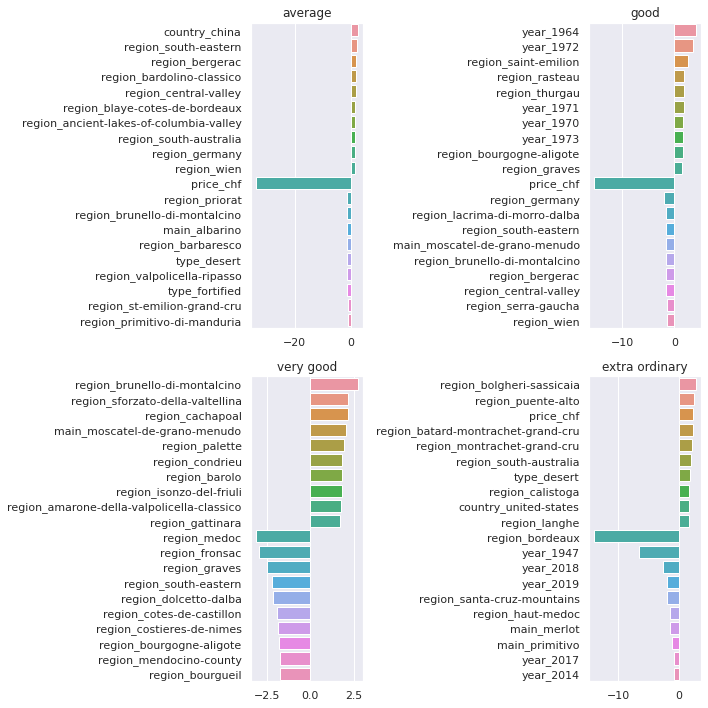

In [224]:
fig, axes = plt.subplots(2, 2)
fig.set_size_inches([10,10])

rating_subplot_map = {(0,0): "average", (0,1): "good", (1,0): "very good", (1,1): "extra ordinary" }

for row in range(2):
  for col in range(2):
    rating = rating_subplot_map[(row, col)]
    top_bottom_10 = pd.concat([coefs.sort_values(by = [rating], ascending=False)[rating].head(10),
                    coefs.sort_values(by = [rating], ascending=True)[rating].head(10)])
    sns.barplot(ax = axes[row, col], x = top_bottom_10.values, y = top_bottom_10.index)
    axes[row, col].set_title(rating)

# 5. PCA Principal Component Analysis to find out important features in the data

PCA can be used to downsize the dimensionality of the dataset while preserving the variance within data points.

In [242]:
%%capture
!pip install pca

In [270]:
from pca import pca

pca_model = pca(n_components=100)
pca_output = pca_model.fit_transform(X_train.toarray())

[pca] >Column labels are auto-completed.
[pca] >Row labels are auto-completed.
[pca] >The PCA reduction is performed on the [1679] columns of the input dataframe.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[5]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


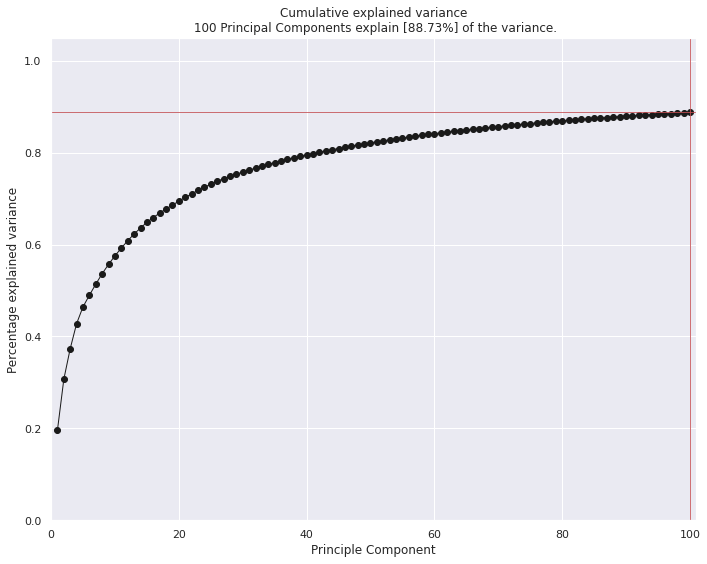

<Figure size 432x288 with 0 Axes>

In [271]:
pca_model.plot();

From the plot above it can be seen that around 100 feature dimensions are enough to preserve 88% of the variance in the dataset. Let us have a look at the top features that contribute the most to the top 100 principal components

In [272]:
pca_important_feature_idx = pca_output['topfeat'][:100]["feature"]
pca_important_feature_names = set([feature_names[idx - 1] for idx in pca_important_feature_idx.values.astype(int)])

print(len(pca_important_feature_names))
pca_important_feature_names

80


{'country_australia',
 'country_austria',
 'country_chile',
 'country_france',
 'country_germany',
 'country_greece',
 'country_portugal',
 'country_south-africa',
 'country_spain',
 'country_switzerland',
 'country_united-states',
 'cuvee_False',
 'main_arinto-de-bucelas',
 'main_baga',
 'main_cabernet-sauvignon',
 'main_chardonnay',
 'main_chenin-blanc',
 'main_corvina',
 'main_gamay',
 'main_grenache-blanc',
 'main_malbec',
 'main_malvasia',
 'main_mencia',
 'main_nebbiolo',
 'main_pinot-noir',
 'main_primitivo',
 'main_shiraz-syrah',
 'main_tempranillo',
 'main_trebbiano',
 'main_unknown',
 'main_verdejo',
 'main_viognier',
 'price_chf',
 'region_alsace',
 'region_alto-adige',
 'region_barolo',
 'region_bordeaux',
 'region_burgenland',
 'region_chateauneuf-du-pape',
 'region_cote-rotie',
 'region_haut-medoc',
 'region_hermitage',
 'region_langhe',
 'region_montsant',
 'region_mosel-saar-ruwer',
 'region_napa-valley',
 'region_pauillac',
 'region_pessac-leognan',
 'region_pfalz',
 '

If you include the above 80 features in the model, you still preserve the 88% of the variance in the data while compressing the number of features from 1679 to 80

# 6. Conclusion

Let us analyze the classification model performance on the hold-out test set that was defined in the beginning of the notebook.

In [229]:
logreg_test_preds = grid_cv.best_estimator_.predict(X_test)
nn_test_preds = categories[np.argmax(model.predict(X_test), axis=1)]

logreg_test_accuracy = metrics.accuracy_score(y_test, logreg_test_preds)
nn_test_accuracy = metrics.accuracy_score(y_test, nn_test_preds)

print(f"Logistic regression classification accuracy on test set: {logreg_test_accuracy}")
print(f"Nueral network classification accuracy on test set: {nn_test_accuracy}")

Logistic regression classification accuracy on test set: 0.6947321692808524
Nueral network classification accuracy on test set: 0.7090855282627997


The wine user rating classification models are performing with 69-70% accuracy for both logistic regression and neural network models. The training analysis shows that the model suffers from high bias and should benefit from more features that can possibly say more about the user ratings of the wines.


---

Since the user ratings classes are imbalanced - there are five times more wines in "good" and "very good" classes in comparison with "average" and "extra ordinary" wines - the accuracy score is dominated by the bigger two classes. The confusion matrix makes this problem apparent.



---



The feature coefficients provided by the logistic regression model gives nice overview on importance of the features on classifiying the training data in target classes. However the coefficients should be treated with care, as  Coefficients in multiple linear models represent the relationship between the given feature,  and the target, assuming that all the other features remain constant (conditional dependence). More details can be found here: https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html


For multiclass classificaiton model, the feature coefficients are given per target class enabling individual importance of the features on various target classes.


---


PCA can be used as a technique to identify most important features that characterize the dataset. In this wine data, the inpute feature space has 1679 dimensions. As an outcome of the PCA analysis it can be shown that 88% of the dataset variance can be kept while downsizing the number of features to only 80. These 80 features are the top features that cahracterizes the dataset the most. However, what PCA analysis doesn't give is the important features that have effect on some target feature such as user ratings.


